In [10]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt

In [11]:
labels = pd.read_csv("./data/samples.csv", dtype={"notes":"str"})

In [12]:
import scipy.io.wavfile
import os

inputpath = "./data" 
inputlength =  5
SR = 16000
outputlength = 4096//2
applyFFT = True

inputfiles = os.listdir(inputpath)

split_into = (inputlength * SR // outputlength)
output_datapoints = len(inputfiles) * split_into
req_inputlength = split_into * outputlength

# X_long = np.zeros((0,80896))

print(f"Splitting each input into {split_into} datapoints, resulting in {output_datapoints} samples")

X1 = np.zeros((output_datapoints, outputlength))
X2 = np.zeros((output_datapoints, outputlength))
y = np.full((output_datapoints, 2), np.nan)

for i, file in enumerate(inputfiles):
    if file.split(".")[1] != "wav":
        continue
    sr, data = scipy.io.wavfile.read(inputpath + "/" + file)
    idx = int(file.split(".")[0])
    if sr != SR:
        raise(f"Samplerate of {file} is {sr} instead of {SR}")
    
    if len(data) < req_inputlength:
        raise(f"File {file} is not long enough")

    # X_long = np.vstack((X_long, data[:,0]))
    
    start_of_block = (len(data) - req_inputlength) // 2
    data_block1 = data[start_of_block:start_of_block+req_inputlength, 1]
    data_block2 = data[start_of_block:start_of_block+req_inputlength, 2]
    X1[i*split_into:(i+1)*split_into, :] = data_block1.reshape((split_into, outputlength))
    X2[i*split_into:(i+1)*split_into, :] = 0.5*(data_block1 + data_block2).reshape((split_into, outputlength))
    y[i*split_into:(i+1)*split_into, :] = np.array((idx, labels.iloc[idx].q_0))

if applyFFT:
    # TODO Hamming (or other) window?
    print("applying FFT")
    X1 = np.abs(np.fft.rfft(X1))
    X2 = np.abs(np.fft.rfft(X2))

print("Combining Results")
X = np.stack([X1, X2], axis=-1)

Splitting each input into 39 datapoints, resulting in 9438 samples
applying FFT
Combining Results


In [13]:
X = np.stack([X1, X2], axis=-1)

In [14]:
X1.shape, X.shape

((9438, 1025), (9438, 1025, 2))

In [16]:
rng = np.random.default_rng(0)
train_fraction = 0.8
train_idx = rng.choice(np.arange(len(labels)), int(len(labels)*train_fraction), replace=False)
train_samples = int(train_fraction*len(X))

X_train = np.zeros((0, *X.shape[1:]))
X_test = np.zeros((0, *X.shape[1:]))
y_train = np.zeros((0,))
y_test = np.zeros((0, ))
for idx in range(len(labels)):
    indizes = y[:,0] == idx
    if idx in train_idx:
        X_train = np.vstack((X_train, X[indizes,:]))
        y_train = np.hstack((y_train, y[indizes,1]))
    else:
        X_test = np.vstack((X_test, X[indizes,:]))
        y_test = np.hstack((y_test, y[indizes,1]))


In [21]:
from sklearn.preprocessing import StandardScaler
scale = StandardScaler()
X_train_scaled = scale.fit_transform(X_train.reshape(-1,X.shape[1]*2)).reshape(-1,X.shape[1],2)
X_test_scaled = scale.transform(X_test.reshape(-1,X.shape[1]*2)).reshape(-1,X.shape[1],2)

In [22]:
import torch
from torch import nn

In [23]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cpu device


In [38]:
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_relu_stack = nn.Sequential(
            nn.Conv1d(2, 8, 16, 4),
            nn.ReLU(),
            nn.Conv1d(8, 8, 16, 4),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(480, 1),
        )

    def forward(self, x):
        x = torch.swapaxes(x, 1, 2)
        output = self.conv_relu_stack(x)
        return output



In [39]:
from torch import optim

network = MLP()

criterion = nn.MSELoss()
optimizer = optim.SGD(network.parameters(), lr=0.005, momentum=0.1) 

# Training loop
epochs = 100  # Number of epochs to train
batch_size = 32  # Batch size for mini-batch gradient descent

X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)

for epoch in range(epochs):
    network.train()  # Set the model to training mode
    permutation = torch.randperm(X_train_tensor.size(0))  # Shuffle the data

    for i in range(0, X_train_tensor.size(0), batch_size):
        indices = permutation[i:i+batch_size]
        batch_x, batch_y = X_train_tensor[indices], y_train_tensor[indices]

        # Zero the gradients from the previous step
        optimizer.zero_grad()

        # Forward pass
        outputs = network(batch_x)

        # Calculate the loss
        loss = criterion(outputs, batch_y)

        # Backward pass (compute gradients)
        loss.backward()

        # Update the weights using the optimizer
        optimizer.step()

    # Print the loss every 10 epochs
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.6f}')

torch.Size([32, 8, 60])


NameError: name 'output' is not defined

In [68]:
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

network.eval()
with torch.no_grad():
    y_pred = network(X_test_tensor)
    print(criterion(y_pred, y_test_tensor))

tensor(0.0348)


In [69]:
deg_preds = np.rad2deg(y_pred.numpy()) 

In [70]:
deg_preds.shape

(1872, 1)

(-50.0, 50.0)

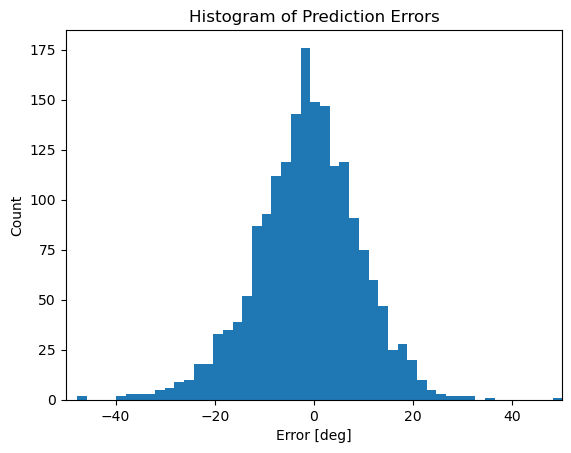

In [71]:
plt.hist(deg_preds.ravel() - np.rad2deg(y_test), bins=50)
plt.gca().set(xlabel="Error [deg]", ylabel="Count")
plt.title("Histogram of Prediction Errors")
plt.xlim((-50,50))

In [72]:
def make_errorbar_plot(y_true, y_pred):
    y_pred = y_pred.reshape(-1, split_into)
    x = y_true[::split_into]
    avg = np.average(y_pred, axis=1)
    std = np.std(y_pred, axis=1)

    plt.figure(figsize=(7,7))
    plt.plot((-70,50), (-70,50), c="orange", label="ground truth")
    plt.errorbar(x, avg, std,fmt='o', label="predicted values")
    plt.axis("equal")
    plt.ylim((-60,40))
    plt.xlabel("True Jointangle")
    plt.ylabel("Predicted Jointangle")
    plt.title("Average of the Linear Regression Predictions")
    plt.legend()

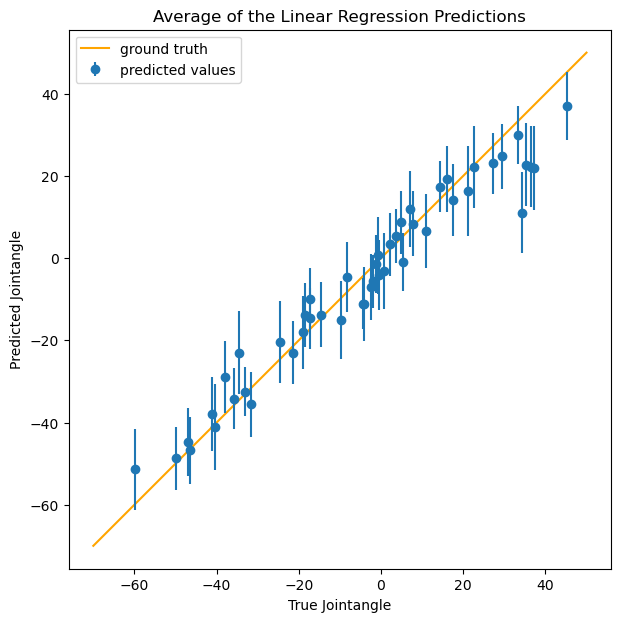

In [73]:
make_errorbar_plot(np.rad2deg(y_test), deg_preds)

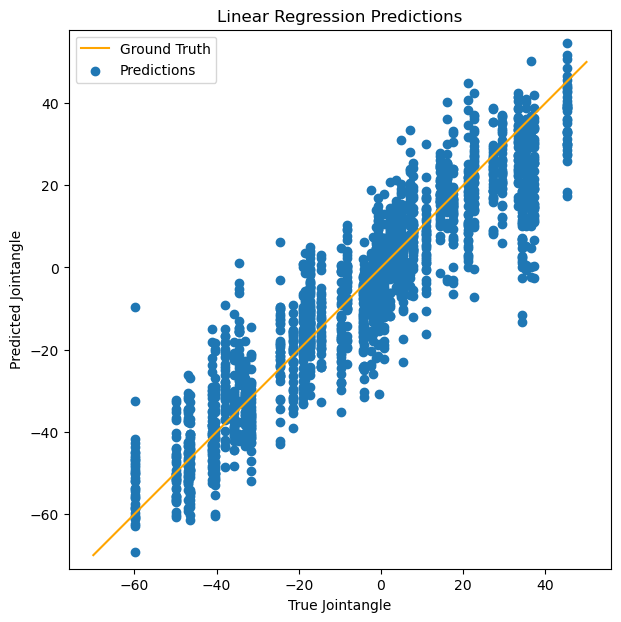

In [74]:
plt.figure(figsize=(7,7))
plt.plot((-70,50), (-70,50), c="orange", label="Ground Truth")
plt.scatter(np.rad2deg((y_test)), deg_preds, label="Predictions")
plt.axis("equal")
plt.gca().set(xlabel = "True Jointangle")
plt.ylabel("Predicted Jointangle")
plt.title("Linear Regression Predictions")
plt.legend()

In [75]:
score = 1 - np.sum((y_pred.numpy().ravel() - y_test)**2) / np.sum((y_test - np.mean(y_test))**2) # R² score
score

np.float64(0.8366263258496697)